# Data Analysis
Notebook to analyse the paraphrasing data generated by this repo.


In [123]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import random
import sys, os

sys.path.append('../')

from src.utils import load_config, split_into_sentences, flatten_list
from src import stats_analysis as sa

In [124]:
##

config = load_config('../config.yaml')


data = pd.read_pickle(config['agg_file'])
data = data.reset_index(drop=True)

data["clean_text"] = data.apply(lambda x: x.altered_text if type(x.text) != str else x.text, axis=1)
data['sentences'] = data.apply(lambda x: split_into_sentences(x.clean_text), axis=1)
data['num_sentences'] = data.apply(lambda x: len(x.sentences), axis=1)

## Data Description

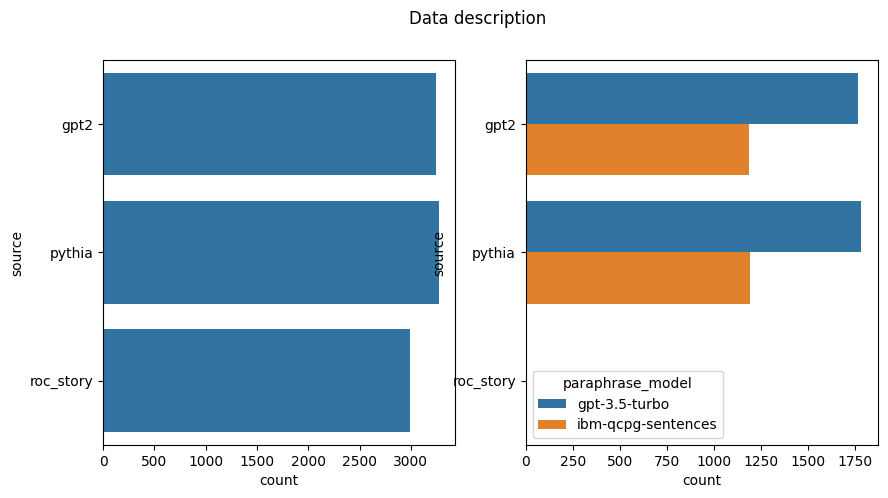

In [125]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))
plt.suptitle(f"Data description")
sns.countplot(data, y="source", ax=axes[0])
sns.countplot(data, y="source", hue = "paraphrase_model", ax=axes[1])

plt.show()

<Axes: xlabel='num_sentences'>

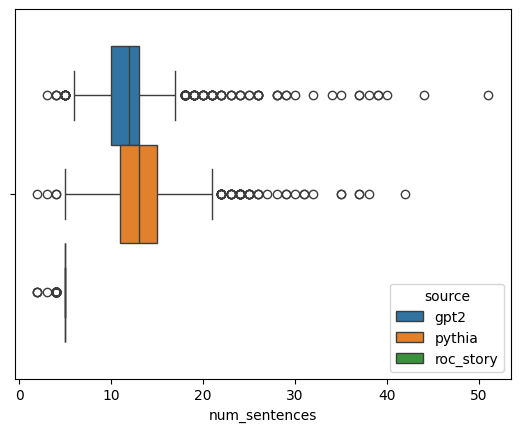

In [126]:
sns.boxplot(data, x="num_sentences", hue="source")

<Axes: xlabel='temperature'>

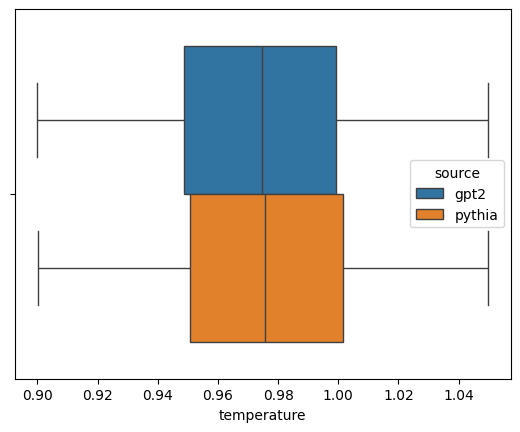

In [128]:
sns.boxplot(data[data.source!="roc_story"], x="temperature", hue="source")

### Analysis of repetitivness metrics without paraphrasing

In [129]:
no_para_data = data[(data['clean_paraphase_type'] ==0) | (data['source'] == "roc_story")]
no_para_data['source'].value_counts()


source
roc_story    2993
gpt2          402
pythia        384
Name: count, dtype: int64

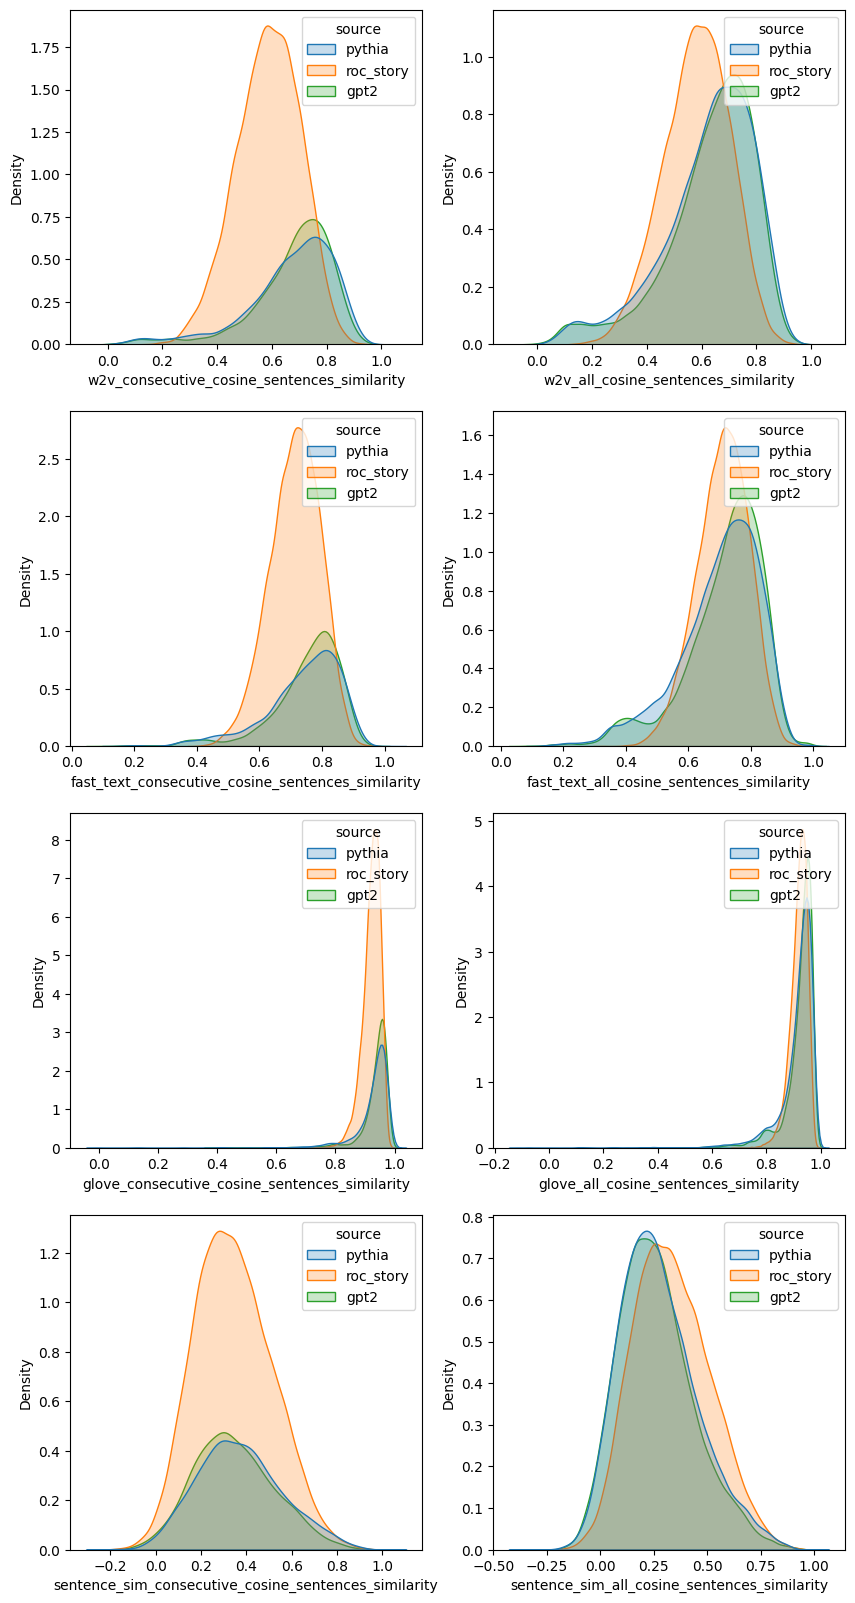

In [130]:
fig, axes = plt.subplots(nrows=4, ncols=2, figsize=(10, 20))
for i,model_name in enumerate(['w2v',"fast_text","glove","sentence_sim"]):
    for j,sim_type in enumerate(['consecutive_cosine_sentences_similarity', 'all_cosine_sentences_similarity']):
        df_compare = pd.DataFrame()
        source_list = []
        sim_list = []
        for source in ["pythia", "roc_story", "gpt2"]:
            sim = flatten_list(no_para_data[no_para_data['source']==source][model_name + '_' + sim_type].tolist())
            source_list.extend([source]*len(sim))
            sim_list.extend(sim)
        df_compare[model_name + '_' + sim_type] = sim_list
        df_compare['source'] = source_list
        sns.kdeplot(x=model_name + '_' + sim_type, hue = "source", data=df_compare, fill=True, common_norm=True, ax=axes[i,j], )#kde=True)
        #axes[i,j].set_title(model_name + '_' + sim_type)
        
        #print(model_name + '_' + sim_type)
        #df_compare['target'] = df_compare['source'].apply(lambda x: 1 if x == 'roc_story' else 0)
        #print(compute_wilcoxon(df_compare, x="target", y=model_name + '_' + sim_type, alt="two-sided") )
plt.show()

In [131]:
data['human_generated'] = data['source'].apply(lambda x: 1 if x == 'roc_story' else 0)
no_para_data = data[(data['clean_paraphase_type'] ==0) | (data['source'] == "roc_story")]

sim_cols = data.filter(regex='mean').columns.tolist()

target = ["human_generated"] #"first_paraphrase"]
results = sa.compute_wilc_table(no_para_data, target,sim_cols, seuil=0.05)
results.head(100)

,x,y,stats,pval,cohen,power
0,human_generated,w2v_consecutive_wmd_sentences_similarity_mean,-11.920656,9.237857e-33,-0.373281,1.000000
1,human_generated,fast_text_all_wmd_sentences_similarity_mean,21.067011,1.597010e-98,0.865357,1.000000
2,human_generated,glove_all_wmd_sentences_similarity_mean,-6.085117,1.164065e-09,-0.171109,0.954630
3,human_generated,glove_consecutive_wmd_sentences_similarity_mean,-17.976017,3.003057e-72,-0.678248,1.000000
4,human_generated,sentence_sim_consecutive_cosine_sentences_simi...,-4.844355,1.270235e-06,-0.179145,0.970750
5,human_generated,sentence_sim_all_cosine_sentences_similarity_mean,16.860816,8.737465e-64,0.639730,1.000000
6,human_generated,lemma_consecutive_jaccard_sentences_similarity...,-2.622861,8.719486e-03,-0.027058,0.029225
7,human_generated,lemma_all_jaccard_sentences_similarity_mean,20.238306,4.503894e-91,0.772559,1.000000


In [132]:
data['human_generated'] = data['source'].apply(lambda x: 1 if x == 'roc_story' else 0)
utils_data = data[(data['clean_paraphase_type'] ==0) & (data['source'] != "roc_story")]

sim_cols = data.filter(regex='similarity').columns.tolist()

target = ["human_generated"] #"first_paraphrase"]
results = sa.compute_wilc_table(utils_data, target,sim_cols, seuil=0.05)
results.head(100)

,x,y,stats,pval,cohen,power


###  Human vs Pythia  and GPT-2
Based on similarity metric, the human generated story are very different from the other two. This is a bit unexpected to found such difference in the non-paraphrased dataset.

## Pythia  vs GPT-2
We do not observe differences between pythia and gpt-2 stories.

In [133]:
data['paraphrase_model'].value_counts()

paraphrase_model
gpt-3.5-turbo         3549
ibm-qcpg-sentences    2377
Name: count, dtype: int64

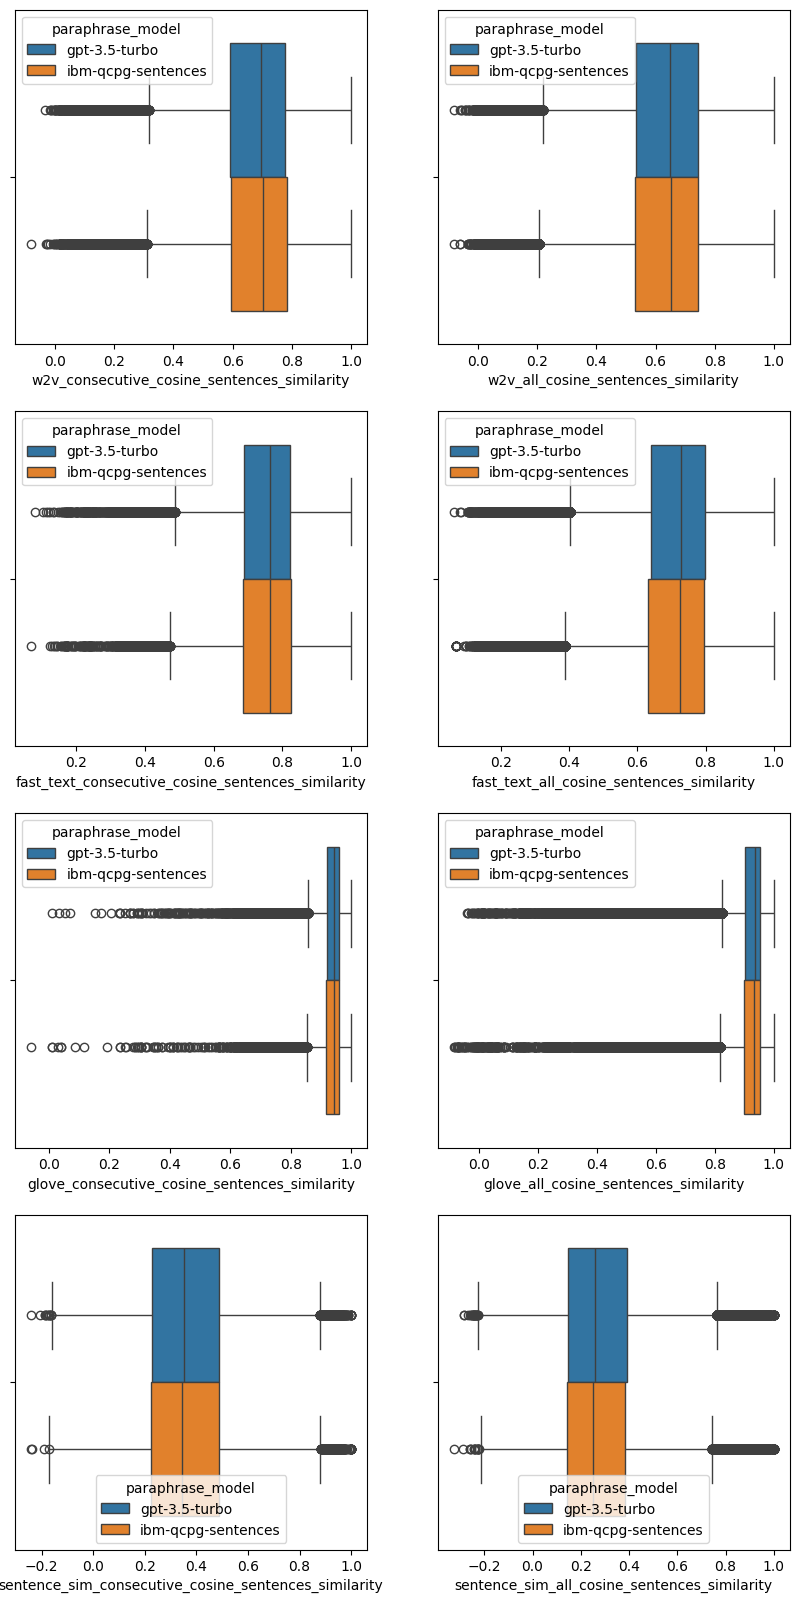

In [136]:
fig, axes = plt.subplots(nrows=4, ncols=2, figsize=(10, 20))
para_data = data[(data['clean_paraphase_type'] !=0) & (data['source'] != "roc_story")]
for i,model_name in enumerate(['w2v',"fast_text","glove","sentence_sim"]):
    for j,sim_type in enumerate(['consecutive_cosine_sentences_similarity', 'all_cosine_sentences_similarity']):
        df_compare = pd.DataFrame()
        source_list = []
        sim_list = []
        for paraphrase_model in ["gpt-3.5-turbo", "ibm-qcpg-sentences"]:
            sim = flatten_list(para_data[para_data['paraphrase_model']==paraphrase_model][model_name + '_' + sim_type].tolist())
            source_list.extend([paraphrase_model]*len(sim))
            sim_list.extend(sim)
        df_compare[model_name + '_' + sim_type] = sim_list
        df_compare['paraphrase_model'] = source_list
        #sns.kdeplot(x=model_name + '_' + sim_type, hue = "paraphrase_model", data=df_compare, fill=True, common_norm=True, ax=axes[i,j], )#kde=True)
        sns.boxplot(x=model_name + '_' + sim_type, hue = "paraphrase_model", data=df_compare,  ax=axes[i,j], )#kde=True)

        #axes[i,j].set_title(model_name + '_' + sim_type)

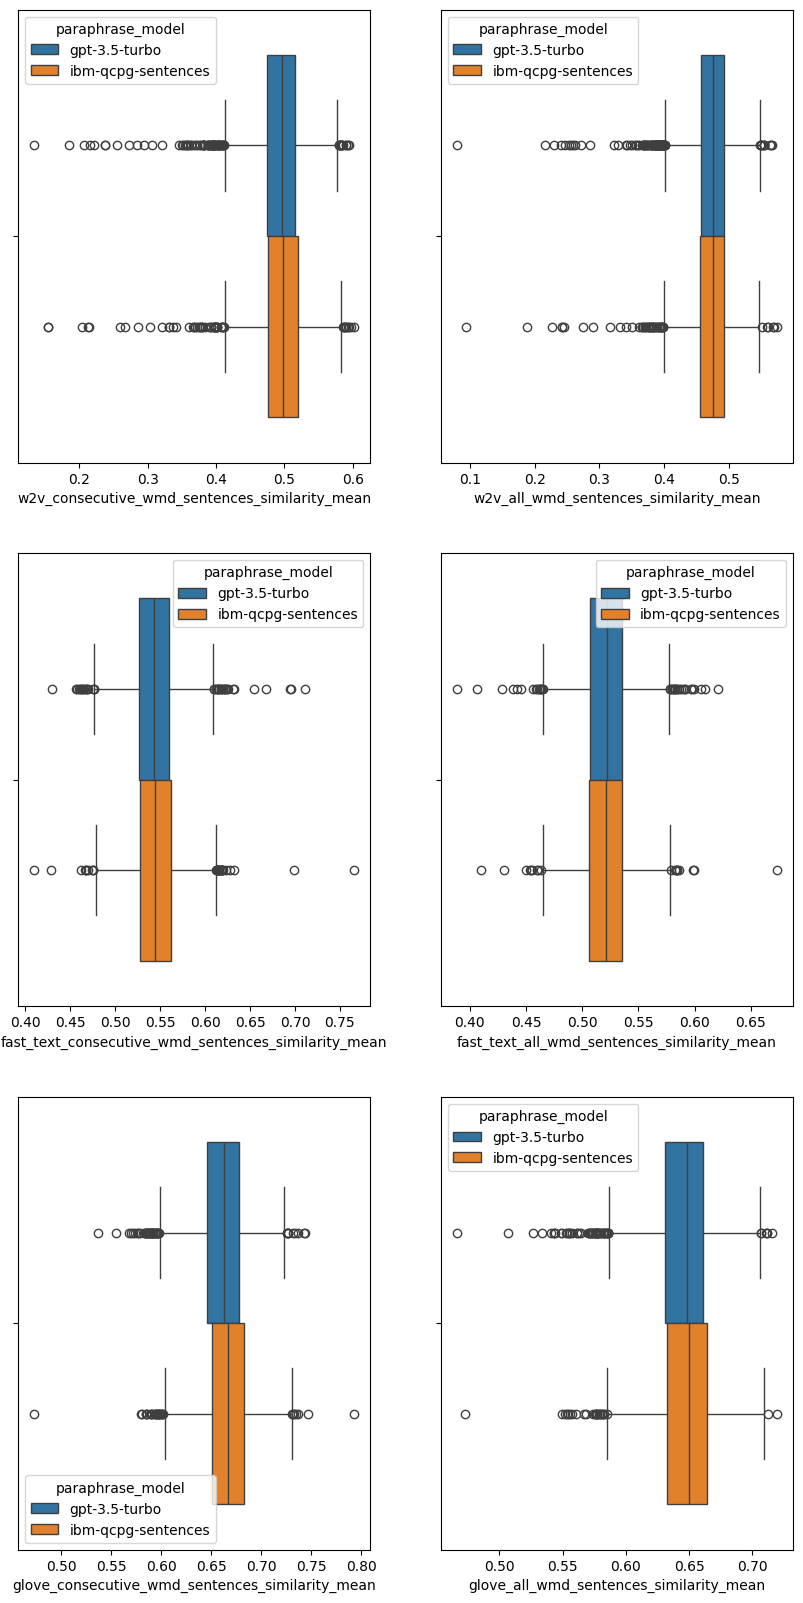

In [137]:
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(10, 20))
para_data = data[data['clean_paraphase_type'] !=0]
for i,model_name in enumerate(['w2v',"fast_text","glove"]):
    for j,sim_type in enumerate(['consecutive_wmd_sentences_similarity_mean', 'all_wmd_sentences_similarity_mean']):
        
        sns.boxplot(x=model_name + '_' + sim_type, hue = "paraphrase_model", data=para_data,  ax=axes[i,j])#kde=True)

        #axes[i,j].set_title(model_name + '_' + sim_type)

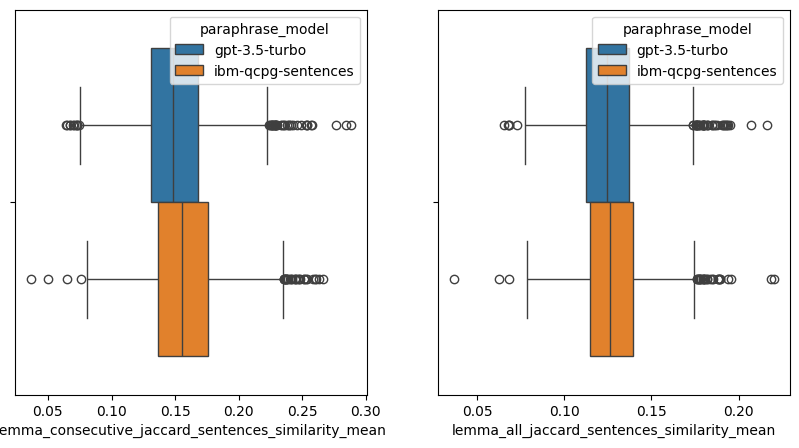

In [141]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))
para_data = data[data['clean_paraphase_type'] !=0]
for i,model_name in enumerate(['lemma']):
    for j,sim_type in enumerate(['consecutive_jaccard_sentences_similarity_mean', 'all_jaccard_sentences_similarity_mean']):
        sns.boxplot(x=model_name + '_' + sim_type, hue = "paraphrase_model", data=para_data,  ax=axes[j])#kde=True)


In [142]:
sim_cols = data.filter(regex='mean').columns.tolist()
para_data['paraphrase_model_enc'] = para_data['paraphrase_model'].apply(lambda x: 1 if x == 'gpt-3.5-turbo' else 0)
target = ["paraphrase_model_enc"] #"first_paraphrase"]
results = sa.compute_wilc_table(para_data, target,sim_cols, seuil=0.05)
results.head(100)

,x,y,stats,pval,cohen,power
0,paraphrase_model_enc,w2v_consecutive_wmd_sentences_similarity_mean,-2.850327,4.367431e-03,-0.072885,0.550876
1,paraphrase_model_enc,fast_text_consecutive_wmd_sentences_similarity...,-3.262117,1.105835e-03,-0.096145,0.839087
2,paraphrase_model_enc,glove_all_wmd_sentences_similarity_mean,-3.402026,6.688833e-04,-0.093073,0.809691
3,paraphrase_model_enc,glove_consecutive_wmd_sentences_similarity_mean,-6.848901,7.441969e-12,-0.189288,0.999996
4,paraphrase_model_enc,sentence_sim_all_cosine_sentences_similarity_mean,4.632881,3.606112e-06,0.116868,0.960747
5,paraphrase_model_enc,lemma_consecutive_jaccard_sentences_similarity...,-9.120231,7.496405e-20,-0.256810,1.000000
6,paraphrase_model_enc,lemma_all_jaccard_sentences_similarity_mean,-3.793885,1.483086e-04,-0.101772,0.884822


### GPT3.5 vs IMB QCGP paraphraser

Based on our similarity metric, we observe that the paraphraser are statistically different, particularly according to the word movers distance and the sentence similarity model with cosine. However we observe small effect sizes.

## Paraphrase analysis

Where ? How many ? etc.

**When:** at which step of the story generation process ?

**Where:** at which position in the story, which sentence ?

**How many:** how many paraphrases are generated ?

**How:** Which model ? Which distance to the original sentence ? 


In [145]:
with_paraphrase = para_data[para_data['clean_paraphase_type']!=0]
# not_roc_data['has_paraphrase'] = not_roc_data['clean_paraphase_type'].apply(lambda x: 1 if x != 0 else 0)

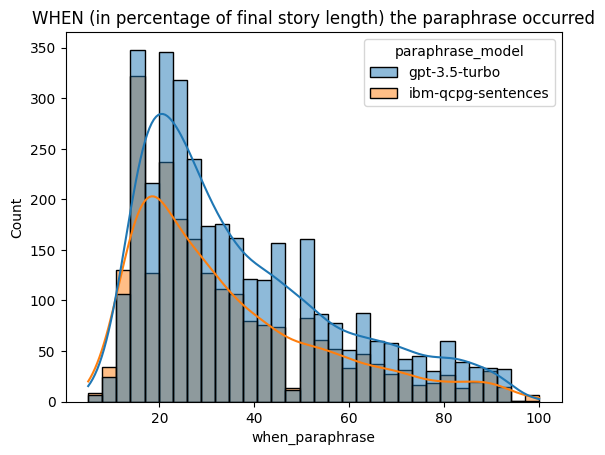

In [146]:
with_paraphrase['when_paraphrase'] = with_paraphrase.apply(lambda x: x.clean_paraphrase_index[1]/x.num_sentences*100, axis=1)
sns.histplot(data = with_paraphrase, x = 'when_paraphrase', hue  = "paraphrase_model", kde = True) 
plt.title("WHEN (in percentage of final story length) the paraphrase occurred")
plt.show()

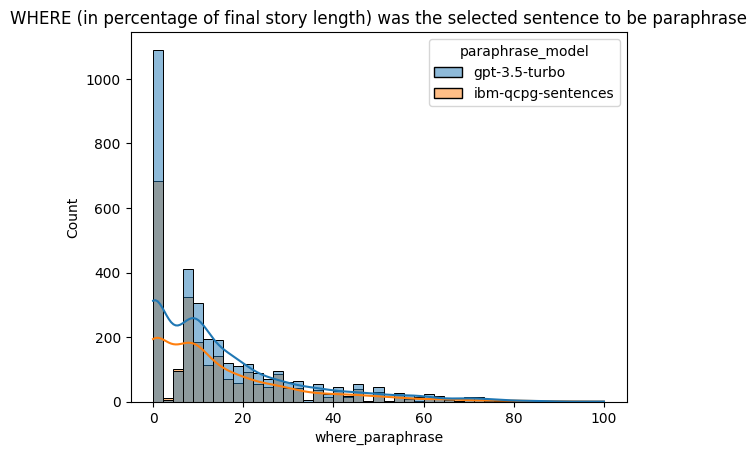

In [147]:
with_paraphrase['where_paraphrase'] = with_paraphrase.apply(
    lambda x: x.clean_paraphrase_index[0]/x.num_sentences*100, axis=1)
sns.histplot(data = with_paraphrase, x = 'where_paraphrase', hue  = "paraphrase_model", kde = True) 
plt.title("WHERE (in percentage of final story length) was the selected sentence to be paraphrase")
plt.show()

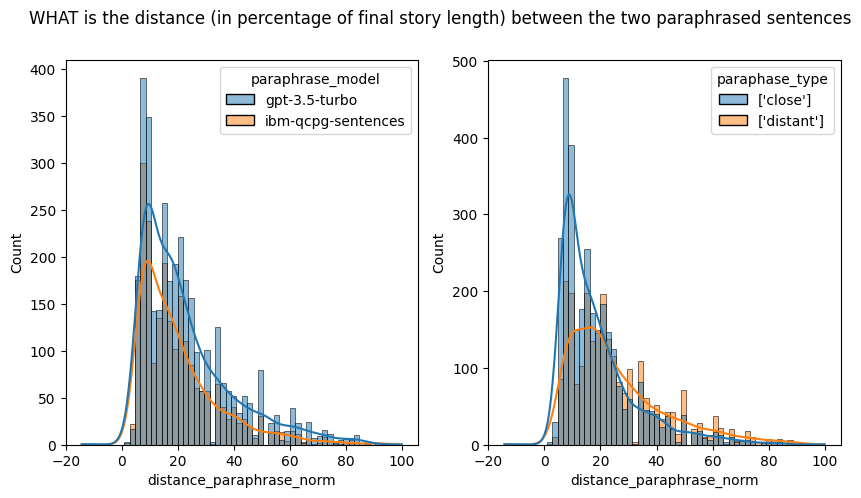

In [148]:
with_paraphrase['distance_paraphrase_norm'] = with_paraphrase.apply(
    lambda x: (x.clean_paraphrase_index[1]-x.clean_paraphrase_index[0])/x.num_sentences*100, axis=1)

hue_a = "paraphrase_model"
hue_b = "paraphase_type"
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))
sns.histplot(data = with_paraphrase, x = 'distance_paraphrase_norm', hue  = hue_a, kde = True, ax=axes[0]) 
sns.histplot(data = with_paraphrase, x = 'distance_paraphrase_norm', hue  = hue_b,kde = True, ax=axes[1])
plt.suptitle("WHAT is the distance (in percentage of final story length) between the two paraphrased sentences")
plt.show()



<Axes: >

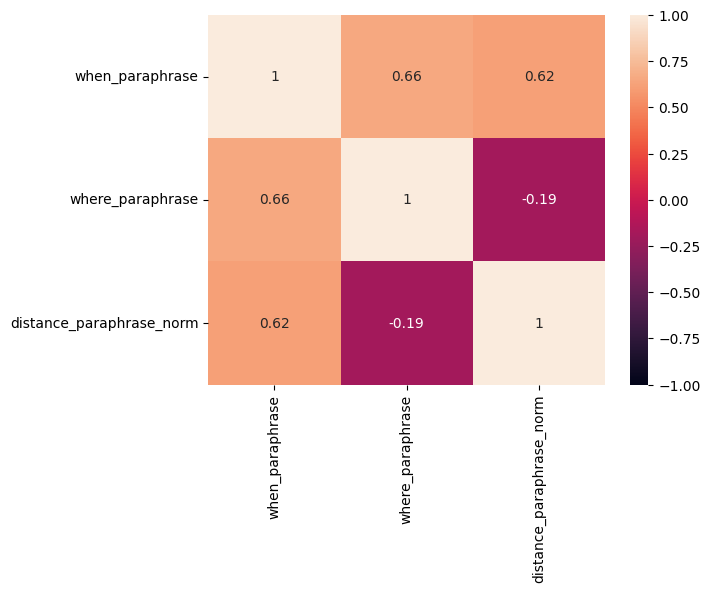

In [149]:
sns.heatmap(with_paraphrase[["when_paraphrase", "where_paraphrase", "distance_paraphrase_norm"]].corr(),vmin=-1, vmax=1, annot=True)

## How similarity metrics can detect paraphrasing ?

The first idea is to check if the similarity metrics are different between two paraphrases vs other sentences.

Then, we want to check ho the metric can identify paraphrasing, semantic repetition. We will compared generated vs generated with online paraphrased. 

First; we will take all the stories.
Then, we will select the story: 
- when the paraphrasing happened at the beginning of the story (<40%).
- where the sentence paraphrased is in the first part of the story (<50%)

We create the following categories:
- *consecutive paraphrasing:* the paraphrased sentence and the target sentence are consecutive.
- *distanced paraphrasing:* the paraphrased sentence and the target sentence are separated from at least 25% of the total length of the.

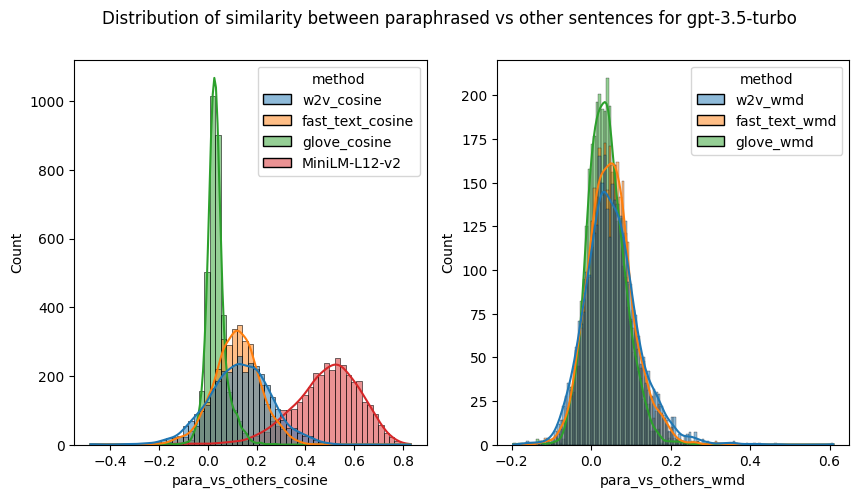

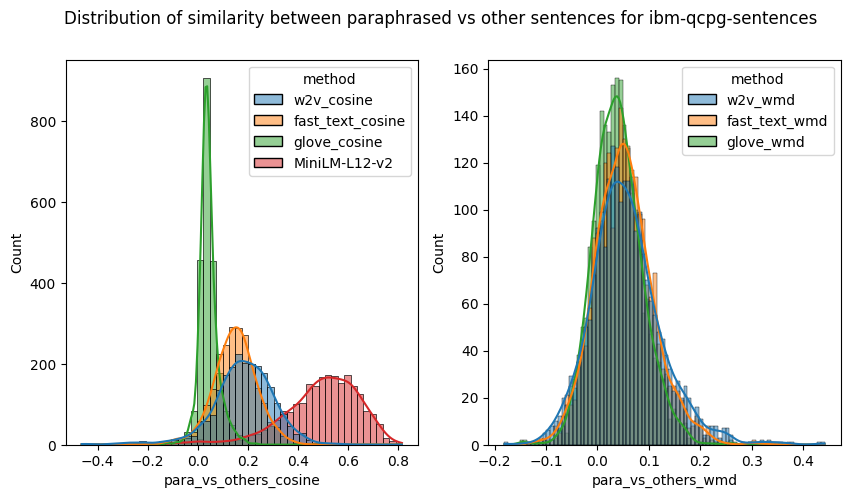

In [151]:
def plot_para_vs_others(with_paraphrase, para_model):
    diff_cosine = pd.DataFrame()
    diff_wmd = pd.DataFrame()
    model_cosine = []
    model_wmd = []
    para_vs_others_cosine= []
    para_vs_others_wmd = []

    for model_name in ['w2v',"fast_text","glove","sentence_sim"]:
        d = with_paraphrase[with_paraphrase['paraphrase_model']==para_model]

        if model_name == 'sentence_sim':
            
            para_vs_others_cosine.append(d[model_name + '_para_vs_others_cosine_sentences_similarity'].tolist())
            name = "MiniLM-L12-v2"
            model_cosine.append([name]*len(d))
        
               
        else :
            for sim_method in ['cosine','wmd']:
                if sim_method == "cosine":
                    para_vs_others_cosine.append(d[model_name + '_para_vs_others_' + sim_method + '_sentences_similarity'].tolist())
                    name = model_name + '_' + sim_method
            
                    model_cosine.append([name]*len(d))
                else :
                    para_vs_others_wmd.append(d[model_name + '_para_vs_others_' + sim_method + '_sentences_similarity'].tolist())
                    name = model_name + '_' + sim_method
            
                    model_wmd.append([name]*len(d))

    diff_cosine['para_vs_others_cosine'] = flatten_list(para_vs_others_cosine)
    diff_cosine['method'] = flatten_list(model_cosine)


    diff_wmd['para_vs_others_wmd'] = flatten_list(para_vs_others_wmd)
    diff_wmd['method'] = flatten_list(model_wmd)

    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))
    plt.suptitle(f"Distribution of similarity between paraphrased vs other sentences for {para_model}")
    sns.histplot( x="para_vs_others_cosine", hue = "method", data=diff_cosine,kde=True, fill=True, ax=axes[0])
    sns.histplot( x="para_vs_others_wmd", hue = "method", data=diff_wmd,kde=True, fill=True, ax=axes[1])
    plt.show()

for para_model in ['gpt-3.5-turbo', 'ibm-qcpg-sentences']:
    plot_para_vs_others(with_paraphrase, para_model)

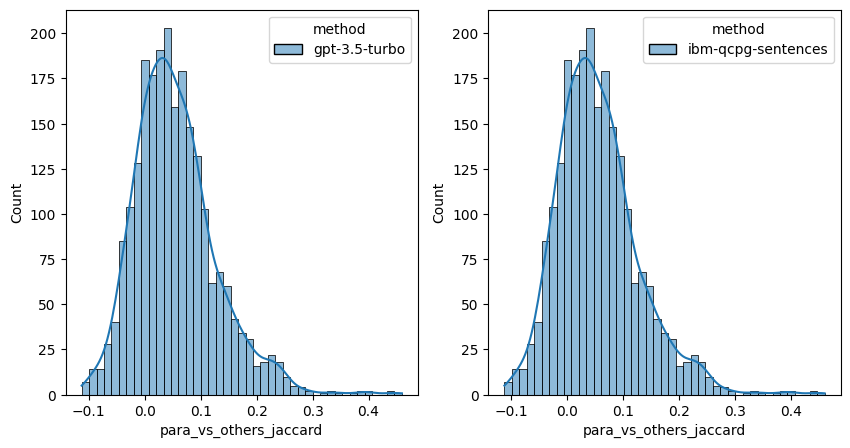

In [155]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))
for i,model in enumerate(['gpt-3.5-turbo', 'ibm-qcpg-sentences']):
    df = pd.DataFrame()
    para_vs_others_jaccard = []
    model_jaccard = [] 
    d = with_paraphrase[with_paraphrase['paraphrase_model']==para_model]
    para_vs_others_jaccard.append(d["lemma" + '_para_vs_others_jaccard_sentences_similarity'].tolist())
    model_jaccard.append([model]*len(d))
    df['para_vs_others_jaccard'] = flatten_list(para_vs_others_jaccard)
    df['method'] = flatten_list(model_jaccard)
    sns.histplot( x="para_vs_others_jaccard", hue = "method", data=df,kde=True, fill=True, ax=axes[i])
plt.show()

Sentence embeddings models seems to be the most sensitive to paraphrasing. Glove is the less sensitive.

In [156]:
# which are the fatures best related to identify paraphrasing
not_roc_data = data[data['source'] != "roc_story"]

not_roc_data['has_paraphrase'] = not_roc_data['clean_paraphase_type'].apply(lambda x: 1 if x != 0 else 0)
not_roc_data['when_paraphrase'] = not_roc_data.apply(lambda x: x.clean_paraphrase_index[1]/x.num_sentences*100 if x.clean_paraphrase_index else -1 , axis=1)
not_roc_data['where_paraphrase'] = not_roc_data.apply(
    lambda x: x.clean_paraphrase_index[0]/x.num_sentences*100 if x.clean_paraphrase_index else -1, axis=1)

not_roc_data['distance_paraphrase_norm'] = not_roc_data.apply(
    lambda x: (x.clean_paraphrase_index[1]-x.clean_paraphrase_index[0])/x.num_sentences*100 if x.clean_paraphrase_index else 0, axis=1)


not_roc_data_filter = not_roc_data[(not_roc_data.when_paraphrase <40) & (not_roc_data.where_paraphrase <50)]

print(f"Total data: {len(not_roc_data)}")
print(f"Total data filtered: {len(not_roc_data_filter)}")


Total data: 6514
Total data filtered: 4508


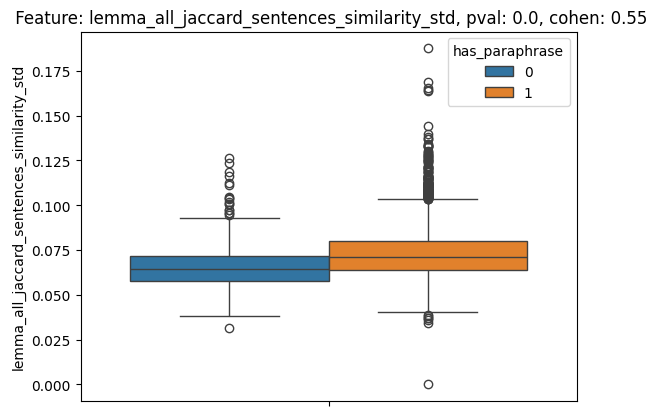

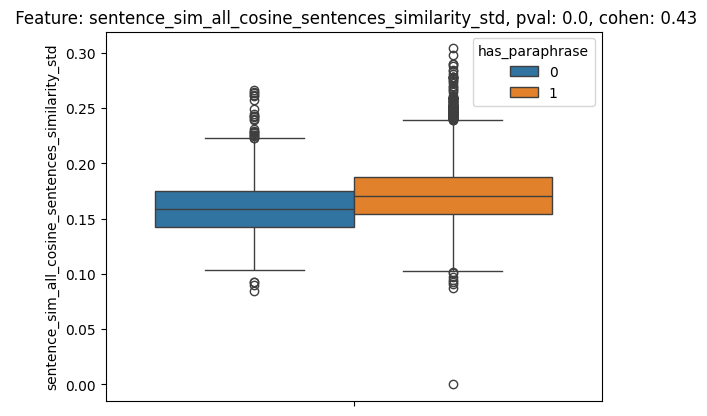

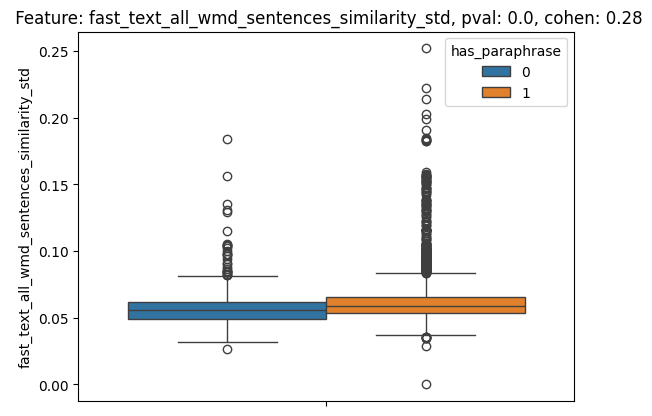

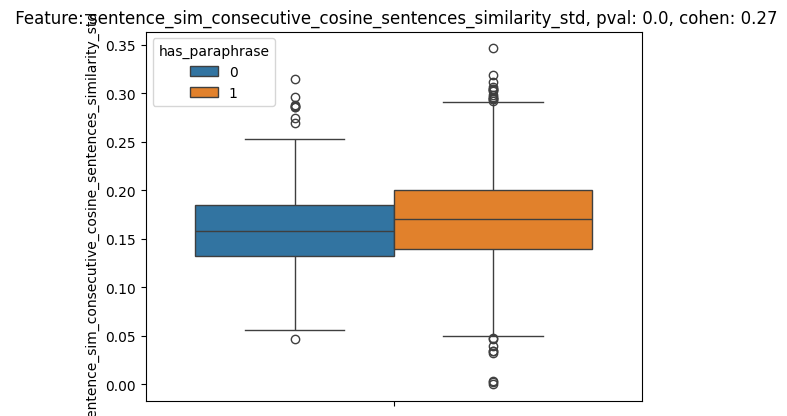

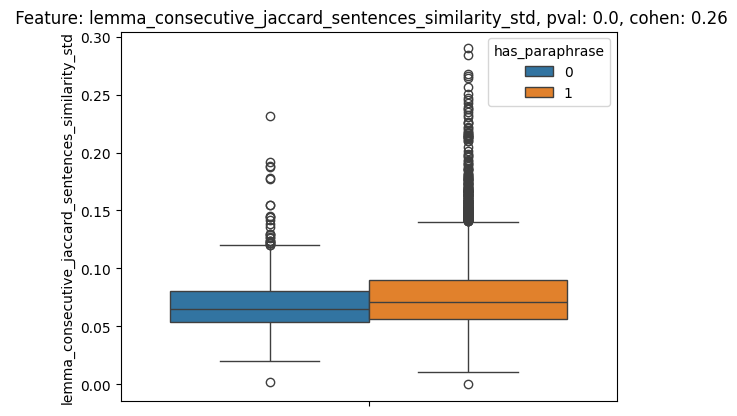

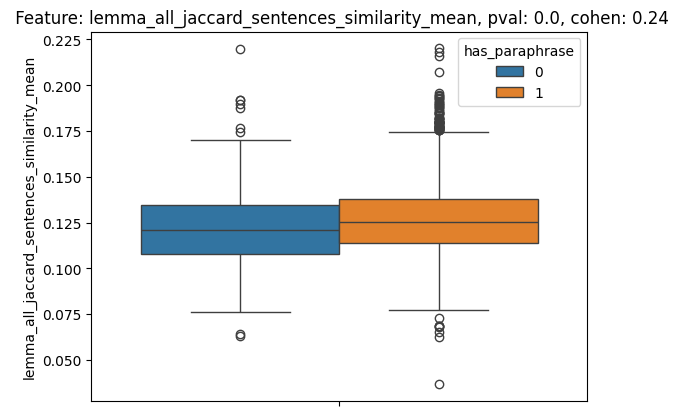

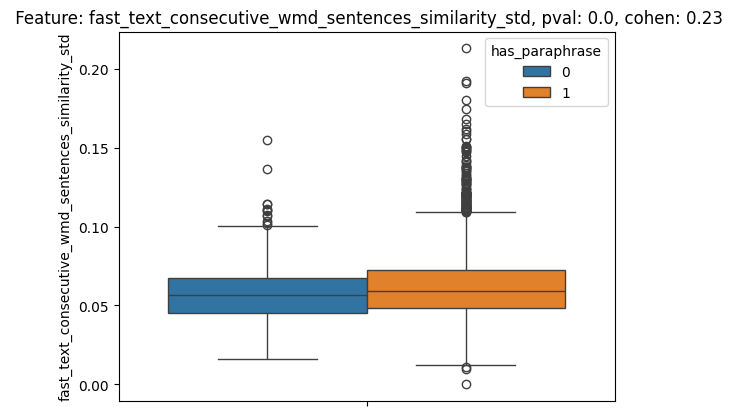

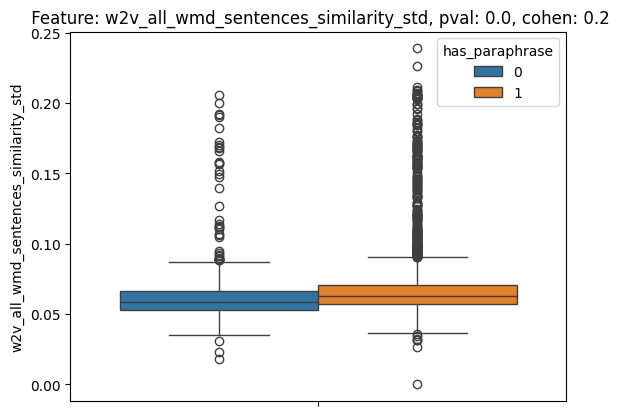

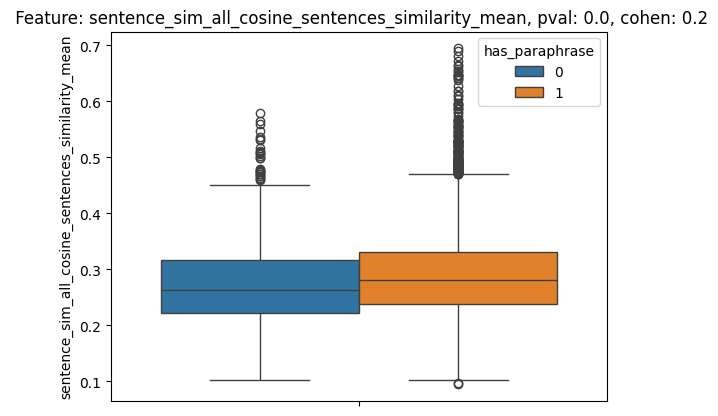

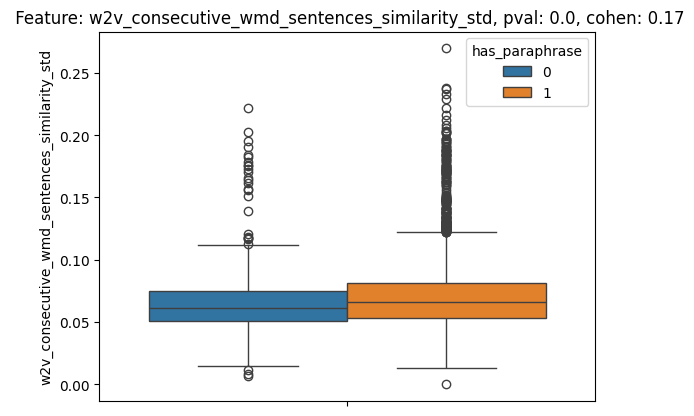

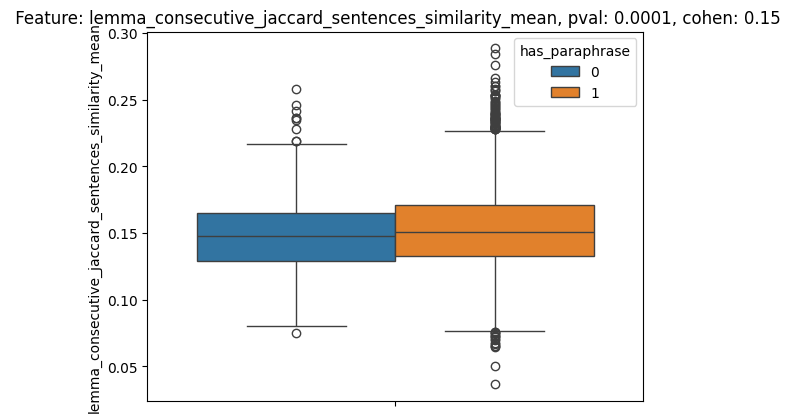

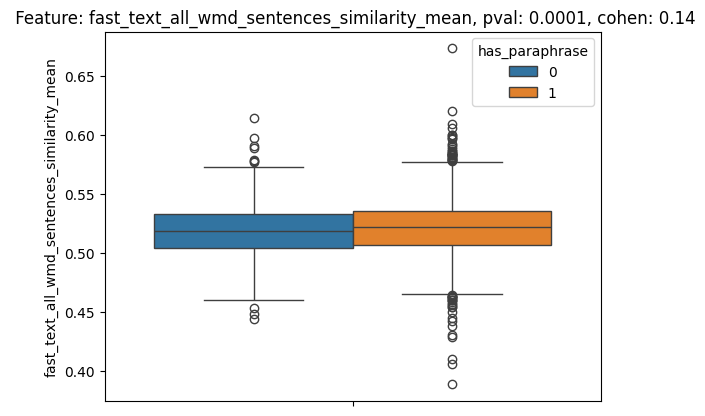

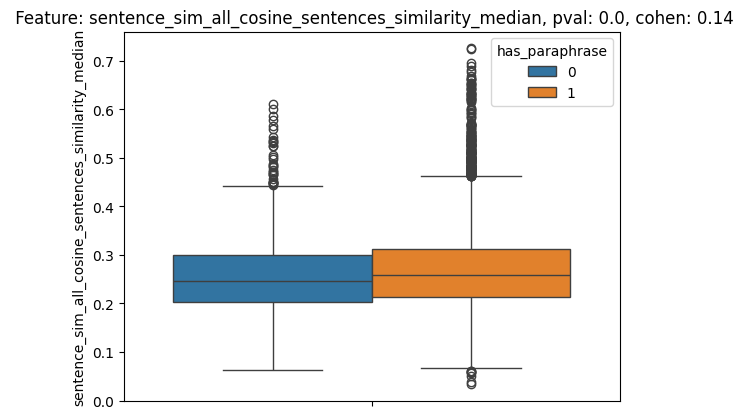

,x,y,pval,cohen,power
17,has_paraphrase,lemma_all_jaccard_sentences_similarity_std,1.327964e-52,0.545145,1.000000
12,has_paraphrase,sentence_sim_all_cosine_sentences_similarity_std,3.468627e-32,0.431942,1.000000
3,has_paraphrase,fast_text_all_wmd_sentences_similarity_std,2.142684e-23,0.282643,0.999999
9,has_paraphrase,sentence_sim_consecutive_cosine_sentences_simi...,1.883395e-12,0.270140,0.999997
14,has_paraphrase,lemma_consecutive_jaccard_sentences_similarity...,3.577019e-11,0.260431,0.999990
15,has_paraphrase,lemma_all_jaccard_sentences_similarity_mean,4.561792e-10,0.240199,0.999907
5,has_paraphrase,fast_text_consecutive_wmd_sentences_similarity...,7.830107e-09,0.231650,0.999778
0,has_paraphrase,w2v_all_wmd_sentences_similarity_std,3.544754e-23,0.198518,0.995877
10,has_paraphrase,sentence_sim_all_cosine_sentences_similarity_mean,3.161492e-09,0.197705,0.995610
1,has_paraphrase,w2v_consecutive_wmd_sentences_similarity_std,1.102835e-07,0.170022,0.970814


In [157]:
sim_features = not_roc_data.filter(regex='mean|std|med|mmin').columns.tolist()
stats = sa.compute_wilc_table(not_roc_data, ["has_paraphrase"],sim_features, seuil=0.01)
stats = stats.sort_values(by="cohen", ascending=False)
select = stats[stats.power>0.8][['x','y',"pval",'cohen','power']]
for features in select['y'].tolist():
    sns.boxplot(data=not_roc_data, hue="has_paraphrase", y=features)
    plt.title(f" Feature: {features}, pval: {select[select.y==features]['pval'].values[0].round(4)}, cohen: {select[select.y==features]['cohen'].values[0].round(2)}")
    plt.show()
select.head(len(select))

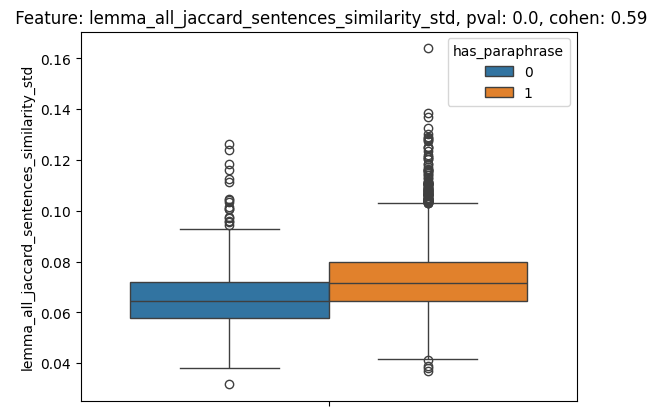

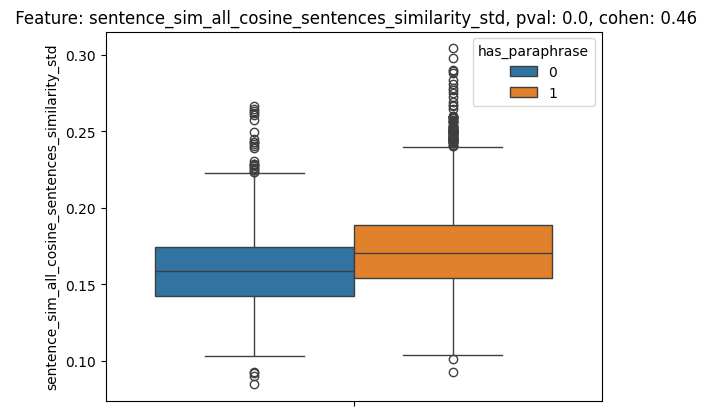

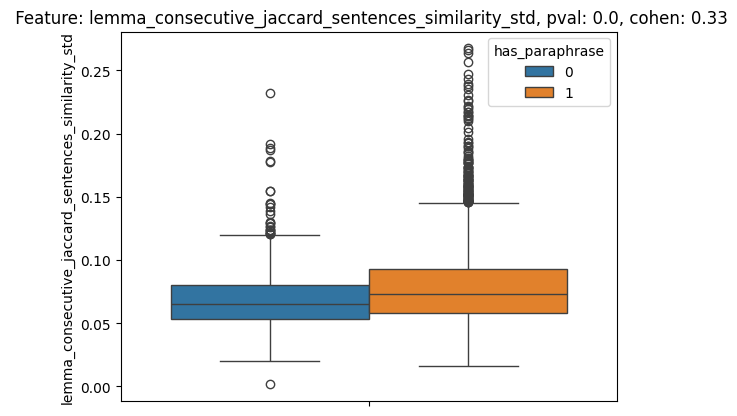

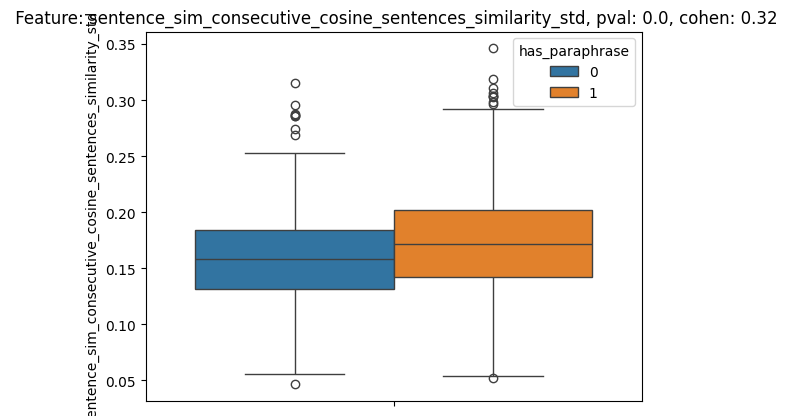

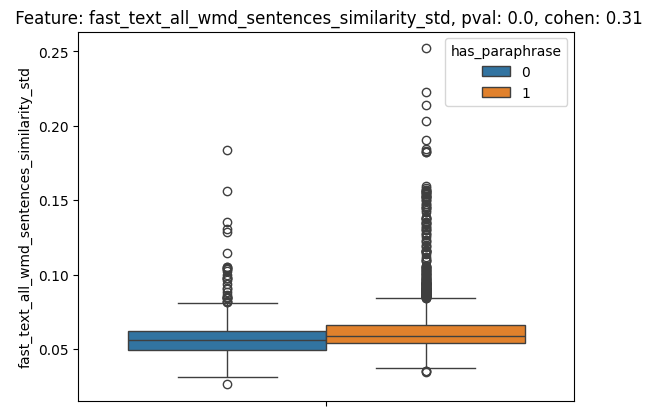

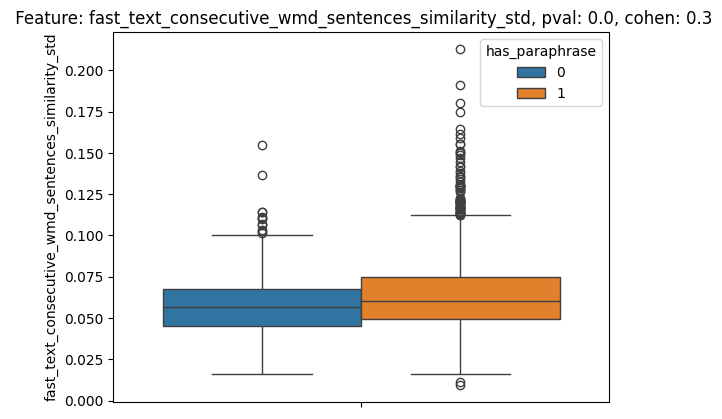

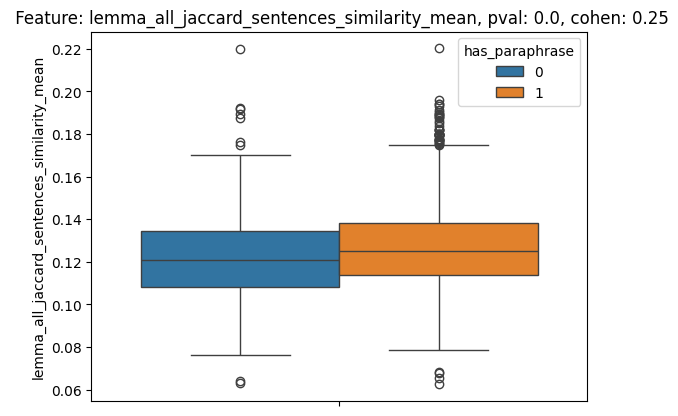

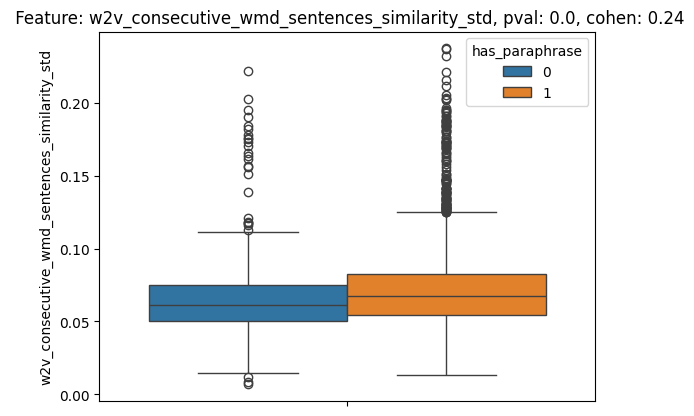

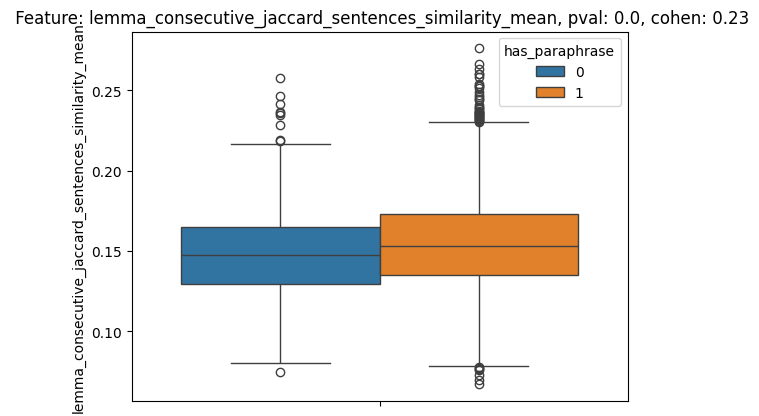

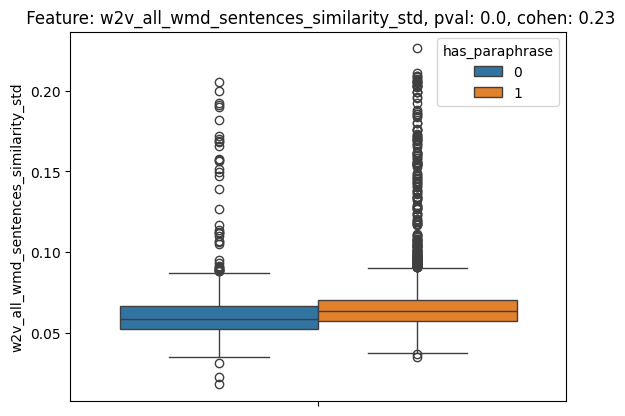

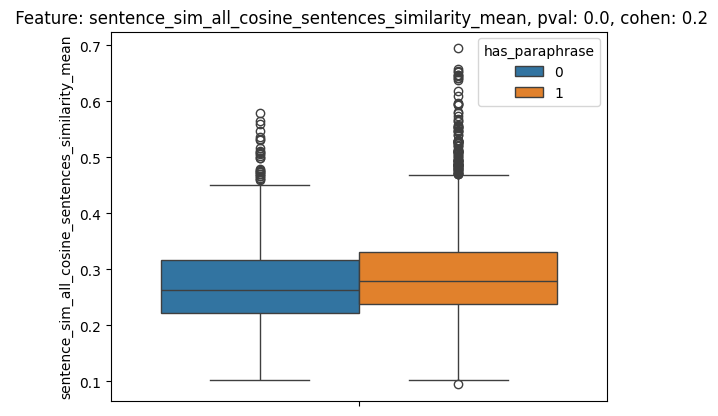

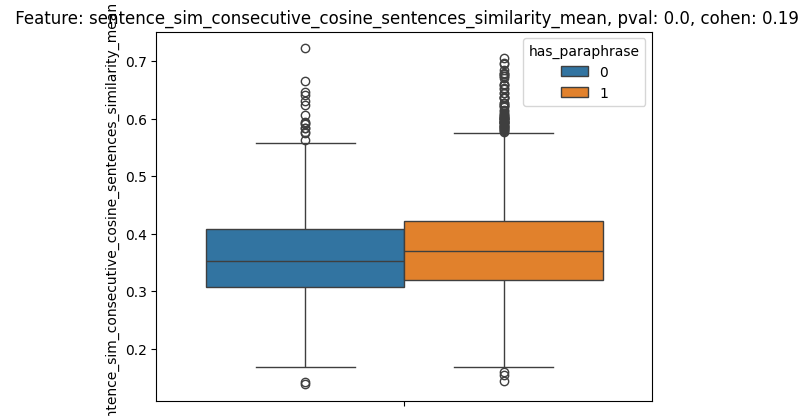

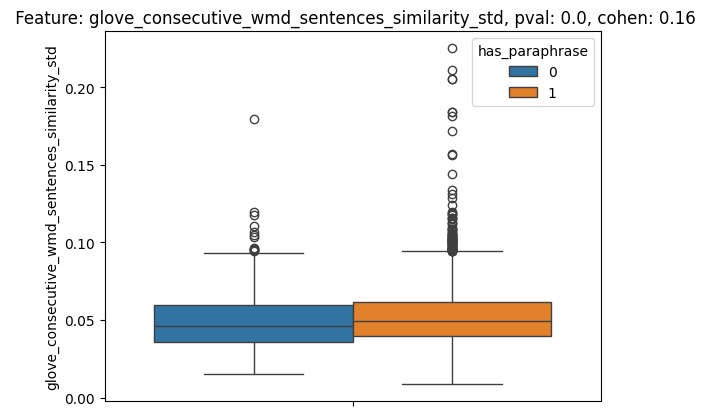

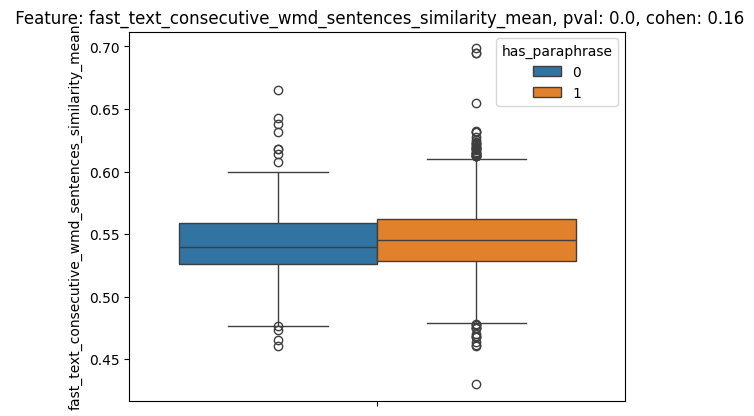

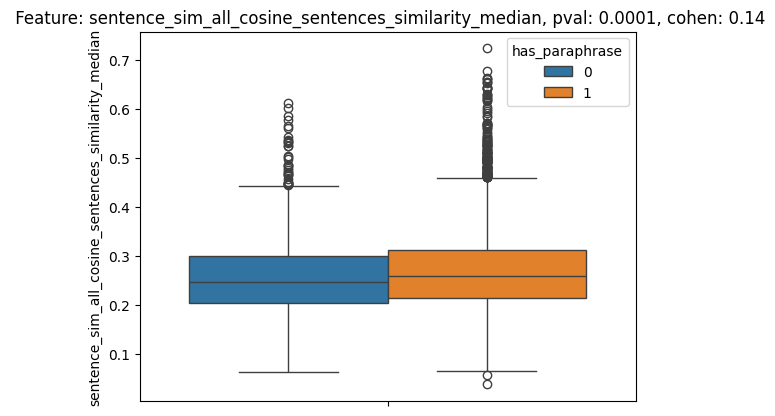

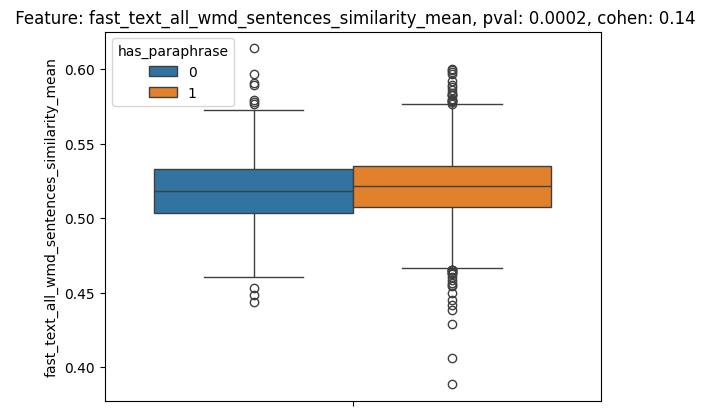

,x,y,pval,cohen,power
20,has_paraphrase,lemma_all_jaccard_sentences_similarity_std,2.182049e-54,0.586966,1.000000
15,has_paraphrase,sentence_sim_all_cosine_sentences_similarity_std,4.470598e-33,0.457120,1.000000
17,has_paraphrase,lemma_consecutive_jaccard_sentences_similarity...,1.721775e-17,0.332550,1.000000
12,has_paraphrase,sentence_sim_consecutive_cosine_sentences_simi...,2.766818e-15,0.317699,1.000000
4,has_paraphrase,fast_text_all_wmd_sentences_similarity_std,1.441075e-25,0.306899,1.000000
6,has_paraphrase,fast_text_consecutive_wmd_sentences_similarity...,2.221153e-13,0.298809,1.000000
18,has_paraphrase,lemma_all_jaccard_sentences_similarity_mean,3.066051e-10,0.253101,0.999945
2,has_paraphrase,w2v_consecutive_wmd_sentences_similarity_std,1.752593e-12,0.236404,0.999714
16,has_paraphrase,lemma_consecutive_jaccard_sentences_similarity...,3.484925e-09,0.230707,0.999515
0,has_paraphrase,w2v_all_wmd_sentences_similarity_std,1.507161e-25,0.225835,0.999251


In [158]:
sim_features = not_roc_data.filter(regex='mean|std|med|mmin').columns.tolist()
stats = sa.compute_wilc_table(not_roc_data_filter, ["has_paraphrase"],sim_features, seuil=0.01)
stats = stats.sort_values(by="cohen", ascending=False)
select = stats[stats.power>0.8][['x','y',"pval",'cohen','power']]

for features in select['y'].tolist():
    sns.boxplot(data=not_roc_data_filter, hue="has_paraphrase", y=features)
    plt.title(f" Feature: {features}, pval: {select[select.y==features]['pval'].values[0].round(4)}, cohen: {select[select.y==features]['cohen'].values[0].round(2)}")
    plt.show()

select.head(len(select))

The standard deviation seams to be a good indicator of paraphrasing. The standard deviation of the similarity between all sentences is higher in text with paraphrasing. The mean is also slightly higher. Again glove is the leat interesting model.

Does this metrics can identify consecutive and  distant paraphrasing ?

In [159]:
study1 = not_roc_data[not_roc_data['has_paraphrase'] == 1]
study1['consecutive_paraphrase'] =study1.apply(lambda x: 1 if (x.clean_paraphrase_index[1]-x.clean_paraphrase_index[0])==1 else 0, axis=1)
study1["distant_paraphrase"] = study1.apply(lambda x: 1 if (x.clean_paraphrase_index[1]-x.clean_paraphrase_index[0])/x.num_sentences>0.25 else 0, axis=1)

In [160]:
target = "consecutive_paraphrase"


print(f"Total data: {len(study1)}")
print(f'{study1[target].value_counts()}')

sim_features = study1.filter(regex='mean|std|med|mmin').columns.tolist()
stats = sa.compute_wilc_table(study1, [target],sim_features, seuil=0.01)
stats = stats.sort_values(by="cohen", ascending=False)
select = stats[stats.power >0.8][['x','y',"pval",'cohen','power']]

#for features in select['y'].tolist():
#    sns.boxplot(data=study1, hue=target, y=features)
#    plt.title(f" Feature: {features}, pval: {select[select.y==features]['pval'].values[0].round(4)}, cohen: {select[select.y==features]['cohen'].values[0].round(2)}")
#    plt.show()

select

Total data: 5728
consecutive_paraphrase
0    3804
1    1924
Name: count, dtype: int64


,x,y,pval,cohen,power
15,consecutive_paraphrase,lemma_consecutive_jaccard_sentences_similarity...,8.063597e-218,0.966104,1.0
11,consecutive_paraphrase,sentence_sim_consecutive_cosine_sentences_simi...,1.878517e-182,0.860925,1.0
5,consecutive_paraphrase,fast_text_consecutive_wmd_sentences_similarity...,1.810495e-176,0.844433,1.0
13,consecutive_paraphrase,lemma_consecutive_jaccard_sentences_similarity...,6.435024e-157,0.806046,1.0
3,consecutive_paraphrase,fast_text_consecutive_wmd_sentences_similarity...,3.794301e-125,0.679010,1.0
2,consecutive_paraphrase,w2v_consecutive_wmd_sentences_similarity_std,3.410462e-126,0.649653,1.0
9,consecutive_paraphrase,sentence_sim_consecutive_cosine_sentences_simi...,9.606568e-109,0.613797,1.0
6,consecutive_paraphrase,glove_consecutive_wmd_sentences_similarity_mean,7.998376e-77,0.516262,1.0
8,consecutive_paraphrase,glove_consecutive_wmd_sentences_similarity_std,9.713873e-76,0.512491,1.0
0,consecutive_paraphrase,w2v_consecutive_wmd_sentences_similarity_mean,3.776725e-92,0.475497,1.0


Total data: 5728
distant_paraphrase
0    4145
1    1583
Name: count, dtype: int64


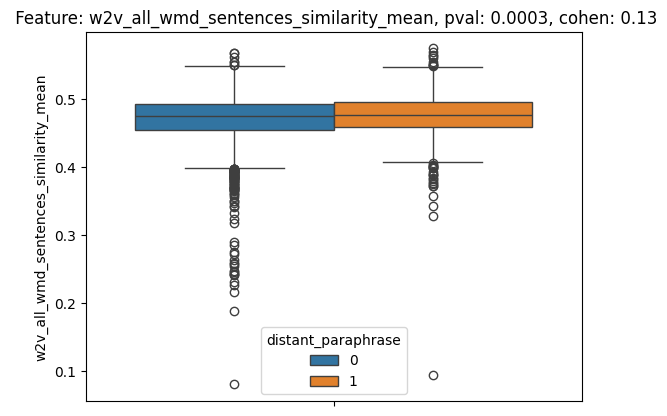

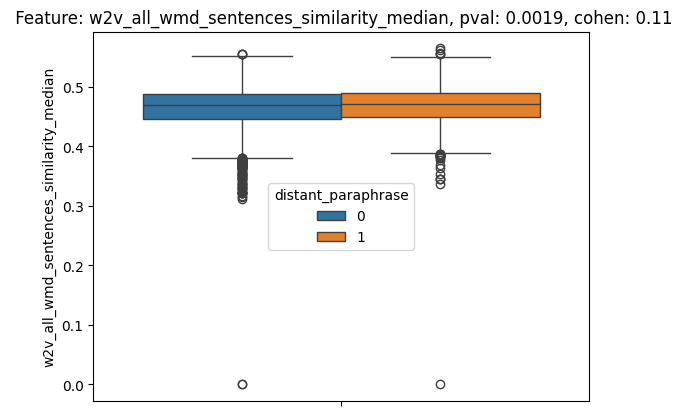

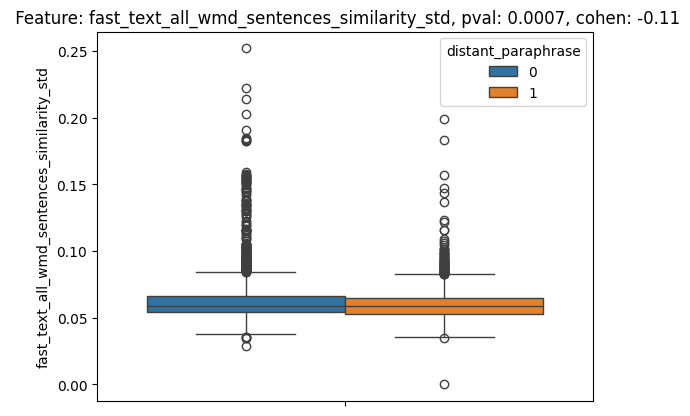

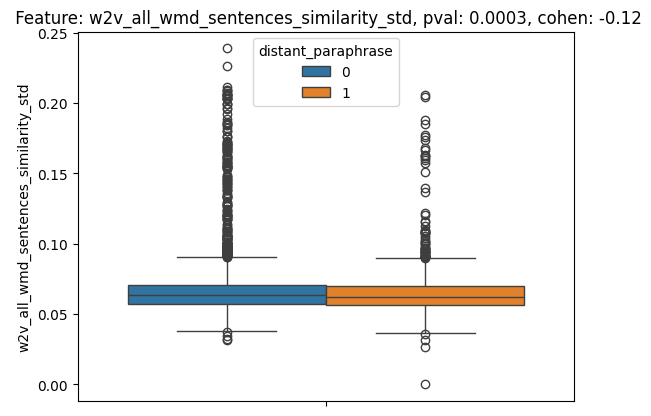

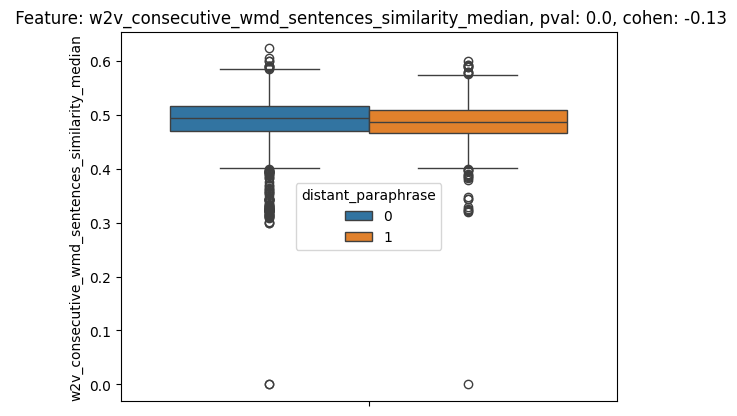

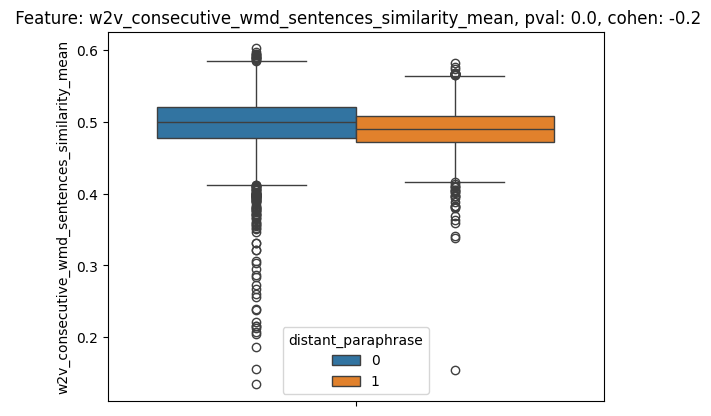

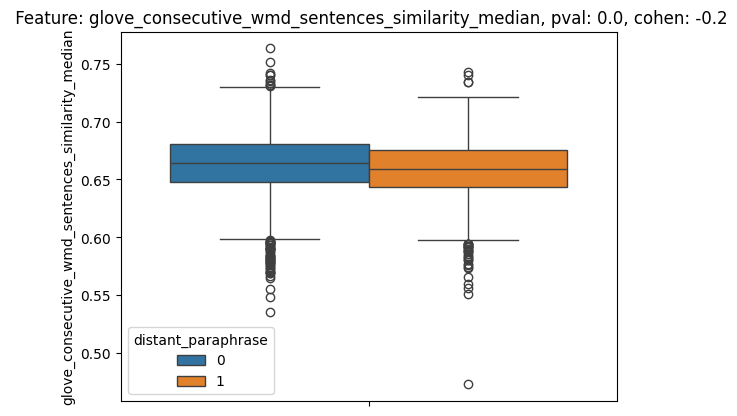

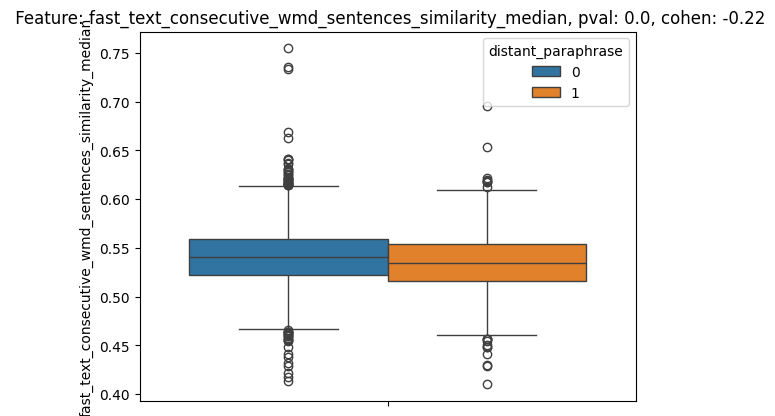

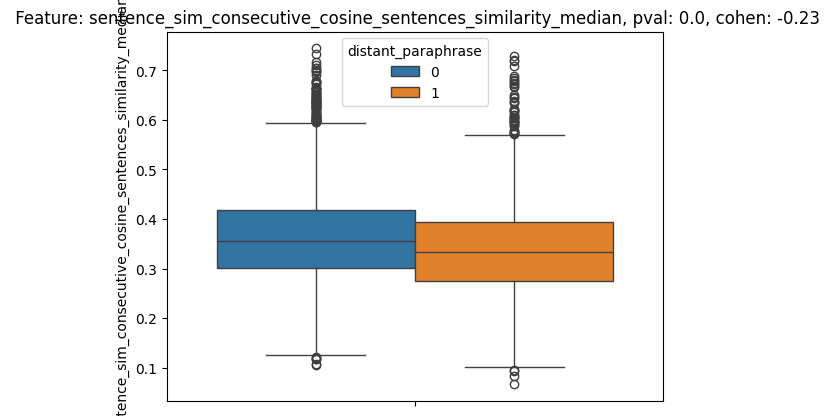

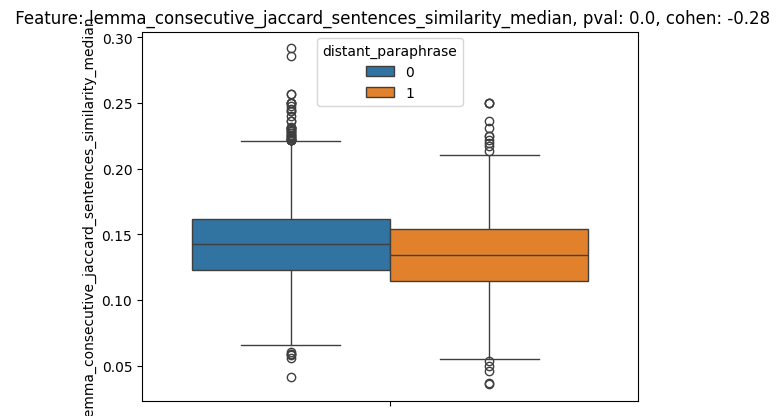

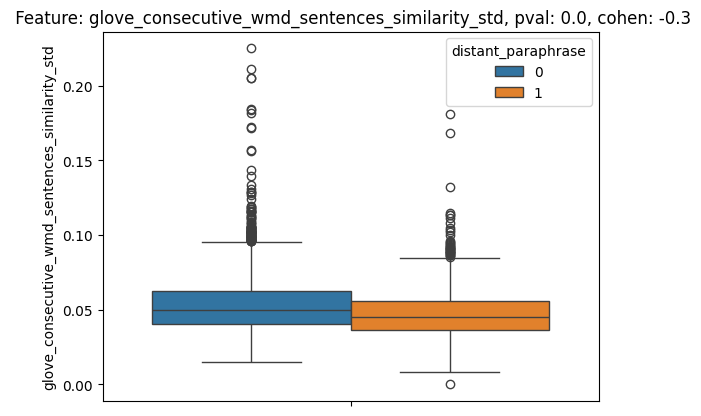

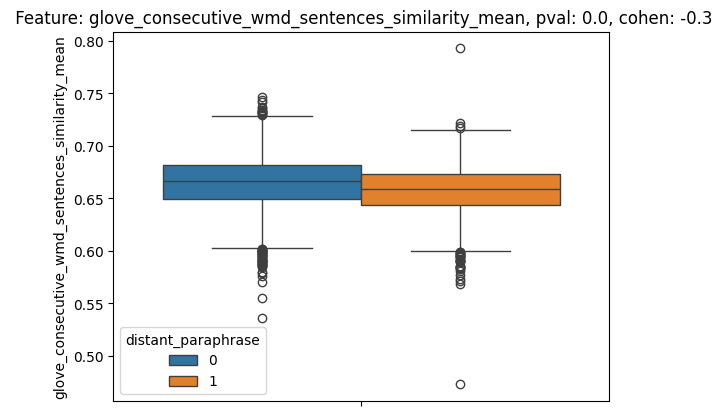

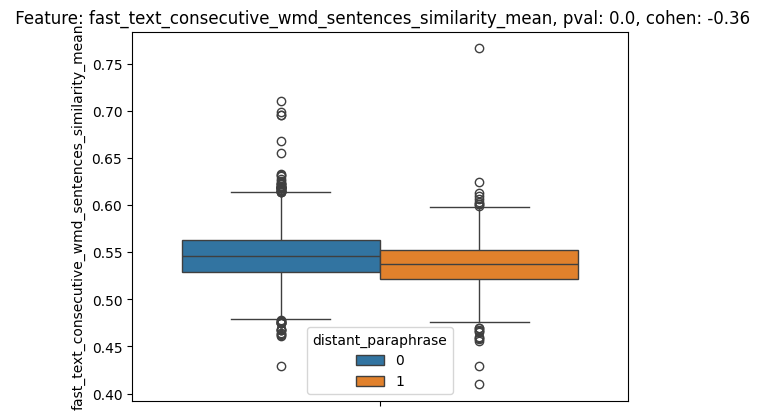

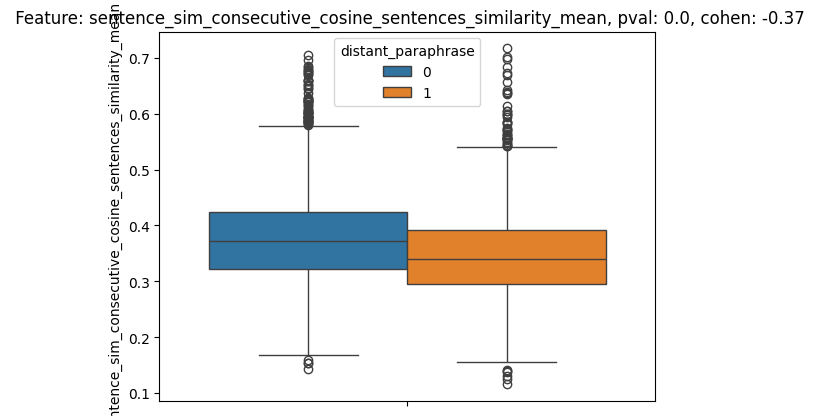

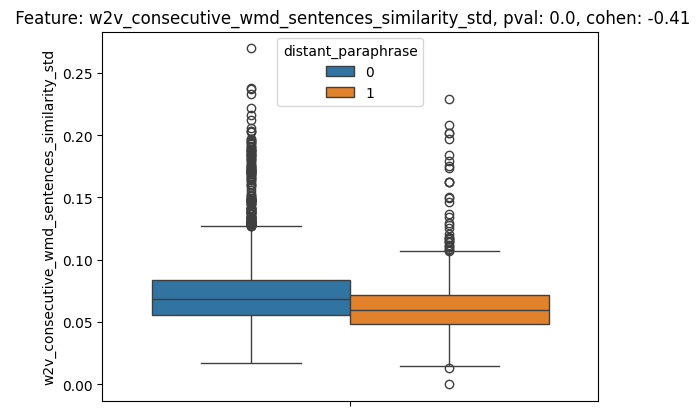

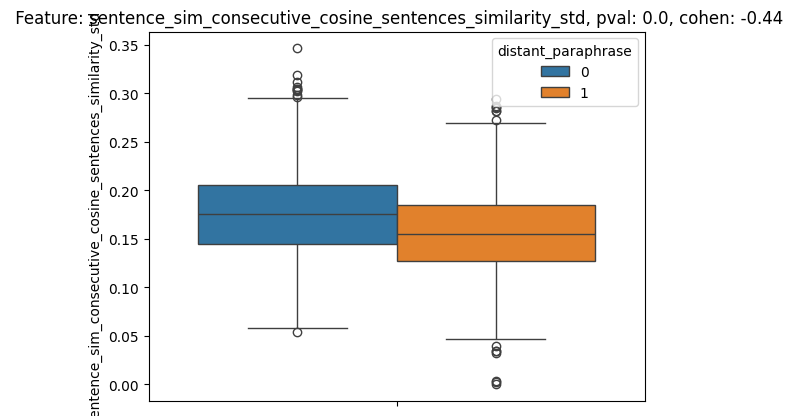

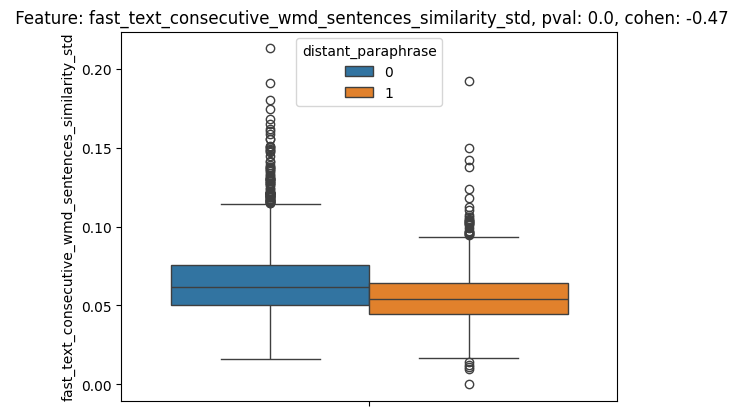

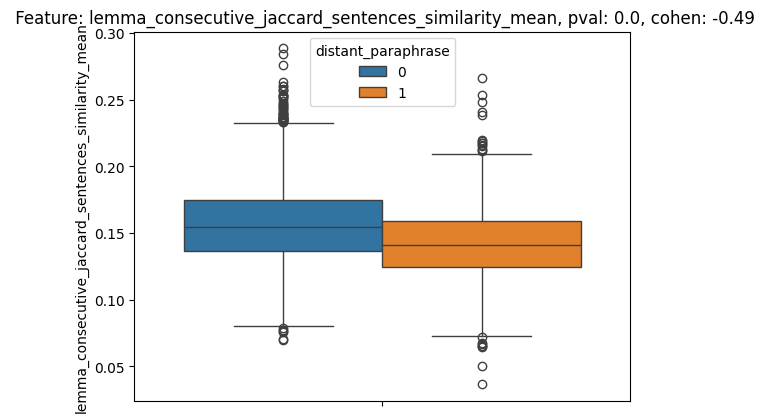

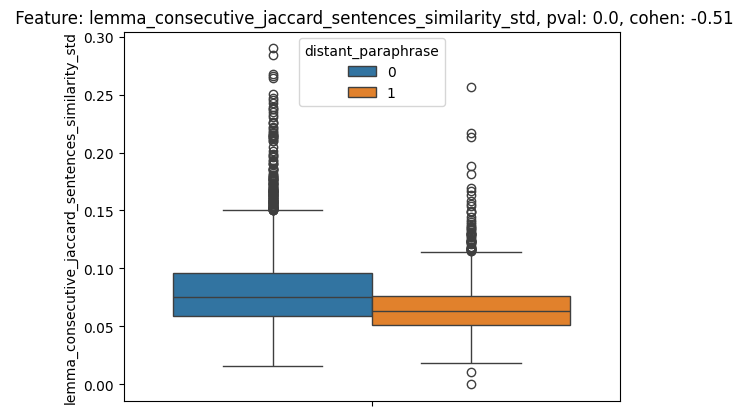

,x,y,pval,cohen,power
0,distant_paraphrase,w2v_all_wmd_sentences_similarity_mean,3.246341e-04,0.134016,0.974927
1,distant_paraphrase,w2v_all_wmd_sentences_similarity_median,1.883323e-03,0.113094,0.894492
6,distant_paraphrase,fast_text_all_wmd_sentences_similarity_std,6.992972e-04,-0.111695,0.885598
2,distant_paraphrase,w2v_all_wmd_sentences_similarity_std,3.232335e-04,-0.123146,0.944184
4,distant_paraphrase,w2v_consecutive_wmd_sentences_similarity_median,8.125756e-10,-0.131536,0.969589
3,distant_paraphrase,w2v_consecutive_wmd_sentences_similarity_mean,2.767985e-20,-0.199431,0.999985
12,distant_paraphrase,glove_consecutive_wmd_sentences_similarity_median,3.177797e-11,-0.200406,0.999987
8,distant_paraphrase,fast_text_consecutive_wmd_sentences_similarity...,4.790742e-13,-0.223035,1.000000
15,distant_paraphrase,sentence_sim_consecutive_cosine_sentences_simi...,8.411042e-18,-0.232953,1.000000
18,distant_paraphrase,lemma_consecutive_jaccard_sentences_similarity...,1.594195e-19,-0.282600,1.000000


In [161]:
target = "distant_paraphrase"


print(f"Total data: {len(study1)}")
print(f'{study1[target].value_counts()}')

sim_features = study1.filter(regex='mean|std|med|mmin').columns.tolist()
stats = sa.compute_wilc_table(study1, [target],sim_features, seuil=0.01)
stats = stats.sort_values(by="cohen", ascending=False)
select = stats[stats.power >0.8][['x','y',"pval",'cohen','power']]

for features in select['y'].tolist():
    sns.boxplot(data=study1, hue=target, y=features)
    plt.title(f" Feature: {features}, pval: {select[select.y==features]['pval'].values[0].round(4)}, cohen: {select[select.y==features]['cohen'].values[0].round(2)}")
    plt.show()

select


This features are also significantly different between the two categories. 
For instance, The standard deviation of consecutive sentences is lower when the paraphrasing is distant. The mean of the word mover distance over all sentences is higher in the distant paraphrasing.

The Jaccard similarity index is very associated with the paraphrasing, that means the praphrased sentences have a lot of words in common with the original sentence. We want to identify the semantic repetition, thus, we want to exclude the paraphrase that are too close in a lexical point of view.

In [175]:
import textdistance
import spacy
nlp = spacy.load('en_core_web_sm')

def compute_jaccard(s1,s2):
    lemma_list_1 = [token.lemma_.lower() for token in nlp(s1)]
    lemma_list_2 = [token.lemma_.lower() for token in nlp(s2)]
    para_sim = textdistance.jaccard.similarity(lemma_list_1, lemma_list_2)

    return para_sim

def compute_jaccard_para_sim(x):
    sentences = x.sentences
    sentences = [s.strip() for s in sentences]
    para_index = x.clean_paraphrase_index
    
    if len(para_index) == 2:
        try : 
            para_sentences = [sentences[para_index[0]], sentences[para_index[1]]]
            para_sim = compute_jaccard(para_sentences[0], para_sentences[1])
        except:
            para_sim = -1
            
    else:
        para_sim = -1
    return para_sim

not_roc_data['jaccard_para_sim'] = not_roc_data.apply(lambda x: compute_jaccard_para_sim(x), axis=1)


<Axes: xlabel='jaccard_para_sim', ylabel='Count'>

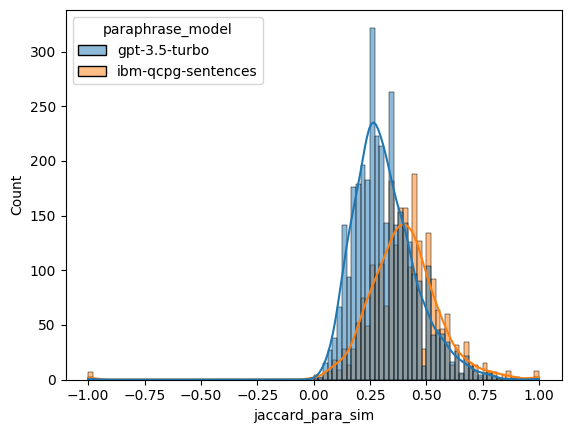

In [176]:
sns.histplot(data = study1, x = 'jaccard_para_sim', hue  = "paraphrase_model", kde = True)

The IBM paraphrasing process produce paraphrase that are lexicaly closer that GPT3.5. We want to see how the features  identify the difficult paraphrase, so we will considered as difficult the paraphrase with jaccard similarity index under the median of our dataset.

In [177]:
jaccard_median = study1['jaccard_para_sim'].median()
not_roc_data['has_semantic repetition'] = not_roc_data['jaccard_para_sim'].apply(lambda x: 1 if 0< x < jaccard_median else  0)
print(jaccard_median)

0.3333333333333333


In [179]:
semantic_repetition_data = not_roc_data[(not_roc_data['has_semantic repetition'] == 1) | (not_roc_data['has_paraphrase'] == 0)]

semantic_repetition_data['has_paraphrase'].value_counts()

has_paraphrase
1    2680
0     786
Name: count, dtype: int64

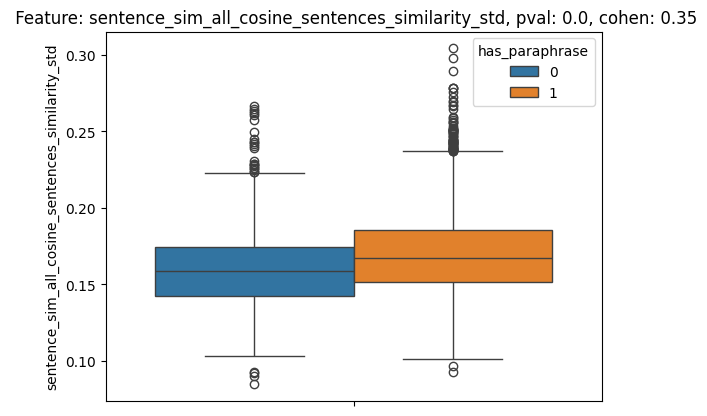

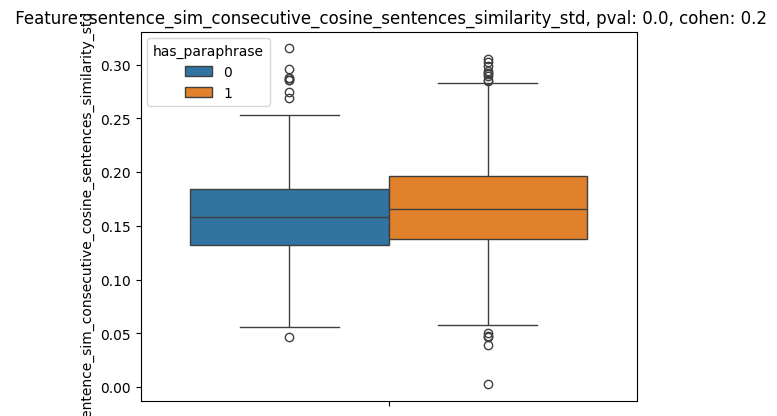

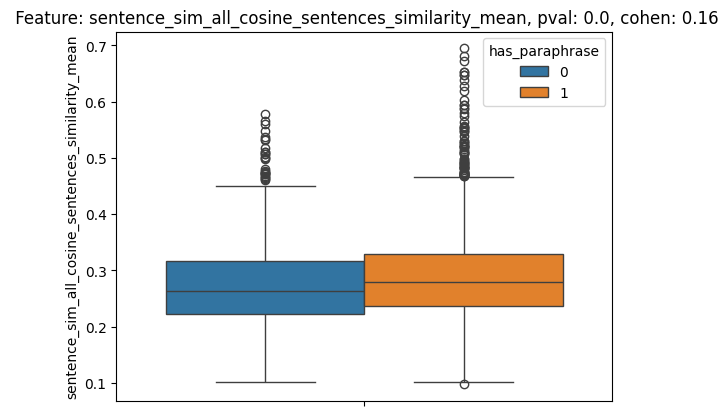

,x,y,pval,cohen,power
5,has_paraphrase,sentence_sim_all_cosine_sentences_similarity_std,7.651644e-19,0.348406,1.000000
2,has_paraphrase,sentence_sim_consecutive_cosine_sentences_simi...,8.921299e-07,0.203904,0.992828
3,has_paraphrase,sentence_sim_all_cosine_sentences_similarity_mean,1.479759e-06,0.164292,0.929553


In [183]:
sim_features = not_roc_data.filter(regex='mean|std|med|mmin').columns.tolist()
stats = sa.compute_wilc_table(semantic_repetition_data, ["has_paraphrase"],sim_features, seuil=0.01)
stats = stats.sort_values(by="cohen", ascending=False)
select = stats[stats.power>0.7][['x','y',"pval",'cohen','power']]
for features in select['y'].tolist():
    sns.boxplot(data=semantic_repetition_data, hue="has_paraphrase", y=features)
    plt.title(f" Feature: {features}, pval: {select[select.y==features]['pval'].values[0].round(4)}, cohen: {select[select.y==features]['cohen'].values[0].round(2)}")
    plt.show()
select.head(len(select))

When removing the paraphrase that are too close in a lexical point of view, the only  features that are still significantly different between has and has not paraphrase are the features based on sentence Embeddings.